# Phase Diagram calculations

- Given a set composition we can use `ptt` to assess the phase stability at different P-T conditions to construct a phase diagram.
- These calculations can be performed with either the MELTS or Holland & Powell family of thermodynamic models (through MAGEMin).
- Also use outputs to assess the variability in key geochemical parameters across P-T space (e.g., phase proportions or chemistry).

**Before any calculations can be run** users need to download the alphaMELTS for MATLAB files and/or install the MAGEMinCalc and juliacall packages. Please see the installation guide on ReadTheDocs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PetThermoTools as ptt

%matplotlib widget

As in all examples we will import the key packages including `ptt`. The only difference here is that we will also use `%matplotlib widget` to make the phase diagram plots interactive (more explanation later).

The cell below can be used for users running MacOS to suppress the outputs (you need to run it twice). I'm still trying to find a better way to deadl with this - if you have suggestions please let me know.

In [3]:
######## RUN twice if using MacOS, ignore if using Windows #########
import sys
import os
sys.stdout = open(os.devnull, 'w')
sys.stderr = open(os.devnull, 'w')

#### Calculations using MELTS

For simplicity we're going to use one of the 'in-built' compostiions from `ptt`, specifically the composition of the KLB-1 peridotite. For the purposes of the MELTS calculations below we will set the K2O content to 0.0 wt% (otherwise the system will always stabilize melt as it doesn't have an alternative option for where to place the K2O). The calculations here will be performed using the "pMELTS" thermodynamic model as it is the most appropriate for mantle conditions and compositions.

In [4]:
KLB1 = ptt.Compositions['KLB-1']
KLB1['K2O_Liq'] = 0.0

We can now run `ptt.phaseDiagram_calc` which takes an array of pressure and temperature conditions and evaluates the equilibrium assemblage at each combination of values. The `i_max` parameters determines the maximum number of iterations that the code will loop through (a new loop is started if one calculation fails) unless every point either has a solution or hits a failure point. In the example below we also specify `refine = 2` this tells `ptt` to create a phase diagram and then look for neighboring points (whether in temperature, pressure or 'diagonally', i.e., both) that have a different phase assemblage. For neighboring points with a different phase assemblage `ptt` will then calculate the equilibrium assemblage at the new, intermediate T-P condition. This approach is very similar to that used in MAGEMin (Riel et al. 2022). The number passed to the `refine` kwarg informs `ptt` how many times you would like it to search for these intermediate points and, therefore, help to refine the location of phase boundaries.

In [5]:
Res = ptt.phaseDiagram_calc(Model = "pMELTS", bulk = KLB1, 
                            P_bar = np.linspace(2000.0,40000.0, 25),
                            T_C = np.linspace(1200.0, 1800.0, 25),
                            i_max = 200,
                            refine = 2)

The result is a DataFrame with 97, equally spaced temperature and pressure values. For cases where the phase assemblage of 2 neighboring points was identical the phase proportions and phase chemistry is estimated through simply linear interpolation between the two neighbors. To view the phase diagram results we can use the `plot_phaseDiagram` function in `ptt`. This will create a phase diagram labelled by number, with each number corresponding to a phase assemblage listed on the right. By using `%matplotlib widget` above you should be able to hover over the plot and see which number (and therefore phase assemblage) is present at each P-T condition.

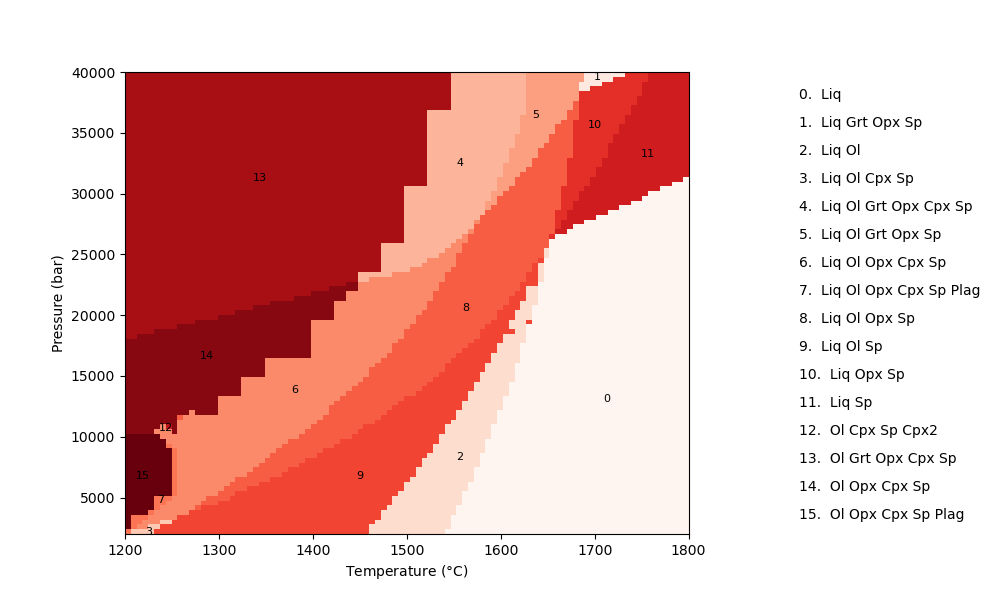

(<Figure size 1000x600 with 2 Axes>,
 array([<Axes: xlabel='Temperature ($\\degree$C)', ylabel='Pressure (bar)'>,
        <Axes: >], dtype=object))

In [6]:
ptt.plot_phaseDiagram(Combined = Res)

#### Calculations using MAGEMin

For calculations with MAGEMin it is important to note that this is one of the major purposes for which the original MAGEMin code was developed, so it will likely always be straightforward to create phase diagrams using the MAGEMinApp (https://github.com/ComputationalThermodynamics/MAGEMinApp.jl). The point of this code is not to try and replace MAGEMin, but to provide Python users with the ability to perform calcualtions with a range of different thermodynamic models.  In the cells below we repeat the calculations above with a few minor differences: (i) MAGEMin (and the Green et al. 2025 thermodynamic model) does not have the same issue as pMELTS when small amounts of K2O are included in the bulk composition; (ii) the `Model` kwarg is changed to `Green2025` which will initiate the calculation in julia via MAGEMin; (iii) currently we do not have the `refine` option working in `ptt` so instead we can just set the number of P and T values to 100 (rather than 25 above).

In [7]:
KLB1 = ptt.Compositions['KLB-1']

In [8]:
Res_green = ptt.phaseDiagram_calc(Model = "Green2025", bulk = KLB1, 
                            P_bar = np.linspace(2000.0,40000.0, 100),
                            T_C = np.linspace(1200.0, 1800.0, 100),
                            i_max = 200)

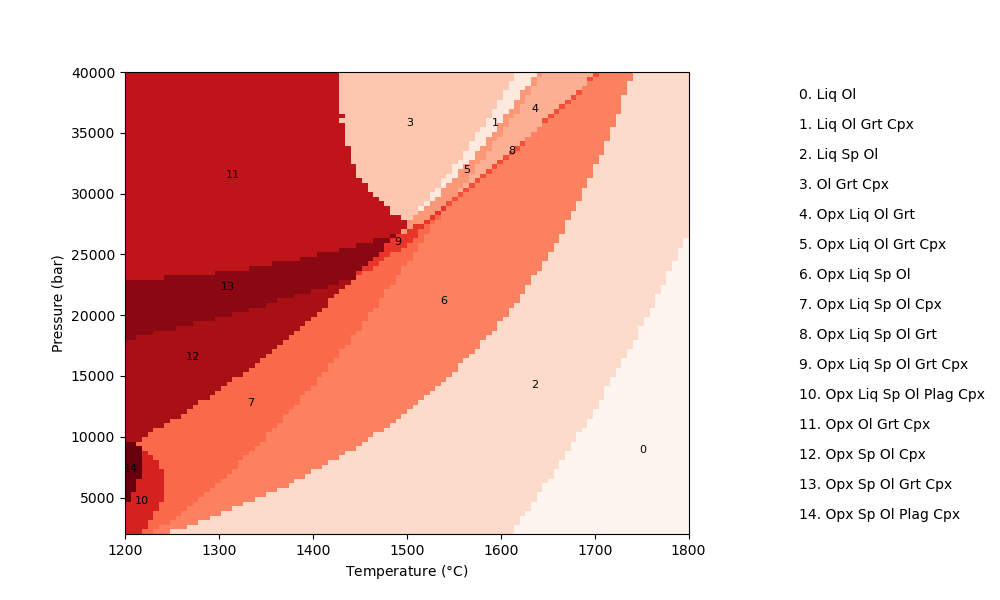

In [9]:
f, a = ptt.plot_phaseDiagram(Combined = Res_green)

### Extracting more information from the phase diagram calculations

In addition to the phase diagrams shown above it is relatively simple to extract additional information from the calculations. For example, it is trivial to extract the mass of liquid (mass fraction) at each point and reshape this array into a P-T grid so that we can visualize this data as contours.

First we need to create a grid of the unique T and P values to get the size and shape of array for our data.

In [10]:
X, Y = np.meshgrid(np.unique(Res_green['T_C']), np.unique(Res_green['P_bar']))

We can then create new variables for each parameter of interest and use the meshgrid above to reshape these parameters correctly.

In [11]:
T = Res_green['T_C'].values.reshape(np.shape(X))
P = Res_green['P_bar'].values.reshape(np.shape(X))
liq = Res_green['mass_Liq'].values.reshape(np.shape(X))

From here we can use the `plt.contourf` function to visualize the mass fraction of melt at each P-T value:

Text(0, 0.5, 'Pressure (bar)')

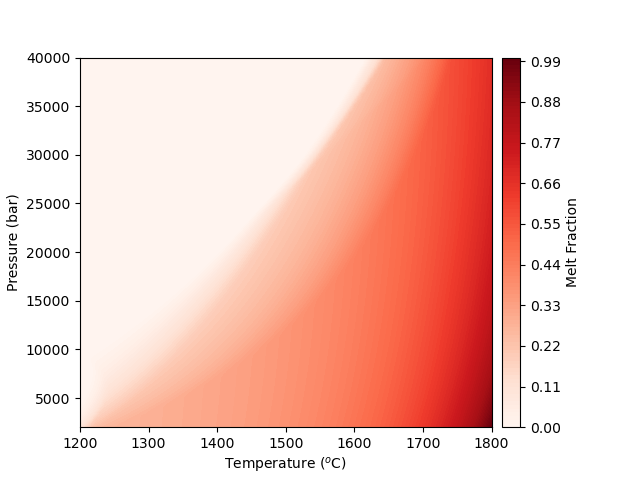

In [16]:
f, a = plt.subplots(1,1)
contour = a.contourf(T, P, liq, cmap='Reds', levels=99)
cbar = f.colorbar(contour, ax=a, orientation='vertical', pad=0.02)  # pad adjusts space between axis and colorbar
cbar.set_label('Melt Fraction')
a.set_xlabel('Temperature ($^o$C)')
a.set_ylabel('Pressure (bar)')

Alternatively we could assess the proportion of garnet and spinel in the system, examining the position of the garnet-spinel transition.

In [17]:
grt = Res_green['mass_Grt'].values.reshape(np.shape(X))
spl = Res_green['mass_Sp'].values.reshape(np.shape(X))

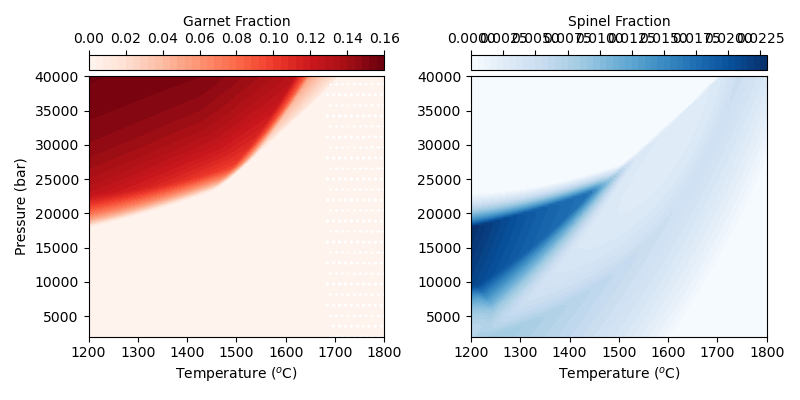

In [18]:
f, a = plt.subplots(1,2, figsize = (8, 4))
contour = a[0].contourf(T, P, grt, cmap='Reds', levels=50)
cbar = f.colorbar(contour, ax=a[0], orientation='horizontal', pad=0.02, location = 'top') 
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_ticks_position('top')

cbar.set_label('Garnet Fraction')
a[0].set_xlabel('Temperature ($^o$C)')
a[0].set_ylabel('Pressure (bar)')

contour2 = a[1].contourf(T, P, spl, cmap='Blues', levels=50)
cbar = f.colorbar(contour2, ax=a[1], orientation='horizontal', pad=0.02, location = 'top')
cbar.set_label('Spinel Fraction')
a[1].set_xlabel('Temperature ($^o$C)')

f.tight_layout()

#### Phase Diagram of pyroxenite lithologies

Alternatively we could create phase diagram for other, potential mantle lithologies. Shown as an example here is a phase diagram calculation for the KG1 pyroxenite.

In [19]:
KG1 = ptt.Compositions['KG1']

In [20]:
KG1_green = ptt.phaseDiagram_calc(Model = "Green2025", bulk = KG1, 
                            P_bar = np.linspace(2000.0,40000.0, 100),
                            T_C = np.linspace(1200.0, 1800.0, 100),
                            i_max = 200)

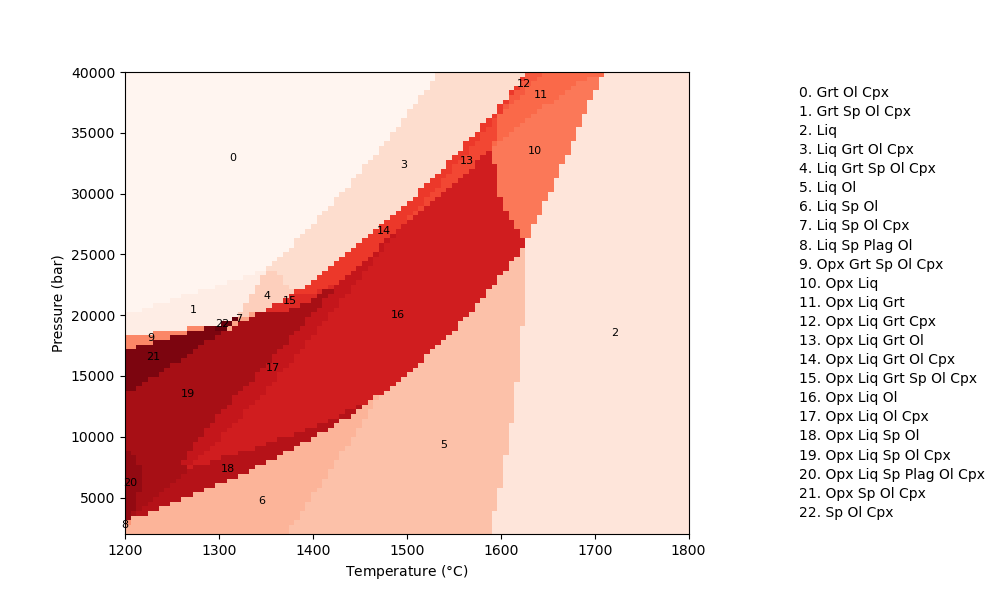

In [21]:
f, a = ptt.plot_phaseDiagram(Combined = KG1_green)